The suscpetible-infected-recovered (SIR) model is a system of nonlinear ODEs given by
\begin{align}
    \frac{dS}{dt} &= \mu N - \mu S - \eta k I S \\
    \frac{dI}{dt} &= \eta k I S - (\gamma+\mu)I \\
    \frac{dR}{dt} &= \gamma I - \mu R.
    \end{align}

where $\gamma$ is the infection rate, $k$ is the contact rate, $r$ is the recovery rate, and $mu$ represents the collective birth and death rate. Each parameter is assumed to take values in the interval [0,1].


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import uniform, beta, gaussian_kde


In [32]:
# SIR model function
def SIR_model(y, t, params, N):
    # Unpack parameters
    gamma, k, r, mu = params
    # Redefine state variables
    S, I, R = y

    # RHS equations
    dSdt = mu*N - mu*S - gamma*k*I*S
    dIdt = gamma*k*I*S - (r + mu)*I
    dRdt = r*I - mu*R
    return [dSdt, dIdt, dRdt]


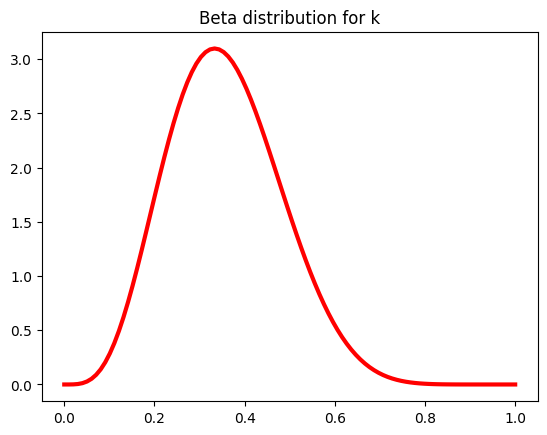

In [40]:
SIR_case = 1
# Initial conditions for the SIR model
S0, I0, R0 = 900, 100, 0
X0 = [S0, I0, R0]
N = np.sum(X0)

# Time variables
t_final = 20
dt = 0.05
t_data = np.arange(0, t_final + dt, dt)

# Assume that mu, eta, and gamma are uniform
M = 10000

# Upper and lower bounds for three of the parameters
gamma_range = [0, 0.1]
r_range = [0, 1.0]
mu_range = [0, 0.5]

# We consider two different distributions for the parameter

if SIR_case == 1:
    alpha, beta_a = 5, 9
else:
    alpha, beta_a = 0.2, 15

# Generate A and B matrices
A = np.zeros((M, 4))
B = np.zeros((M, 4))
A[:, 0] = uniform.rvs(gamma_range[0], gamma_range[1], size=M)
A[:, 1] = beta.rvs(alpha, beta_a, size=M)
A[:, 2] = uniform.rvs(r_range[0], r_range[1], size=M)
A[:, 3] = uniform.rvs(mu_range[0], mu_range[1], size=M)

B[:, 0] = uniform.rvs(gamma_range[0], gamma_range[1], size=M)
B[:, 1] = beta.rvs(alpha, beta_a, size=M)
B[:, 2] = uniform.rvs(r_range[0], r_range[1], size=M)
B[:, 3] = uniform.rvs(mu_range[0], mu_range[1], size=M)

plt.figure()
x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, alpha, beta_a), 'r', lw=3)
plt.title('Beta distribution for k')



# Now generate C, which is the matrix A with one column replaced by B
C_cell = []
for i in range(4):
    C = A.copy()
    C[:, i] = B[:, i]
    C_cell.append(C)

# Lastly, initialize the output storage structure
I_int_A = np.zeros((M, 1))
I_int_B = np.zeros((M, 1))
I_int_C = np.zeros((M, 4))

I_equi_A = np.zeros((M, 1))
I_equi_B = np.zeros((M, 1))
I_equi_C = np.zeros((M, 4))



In [41]:
## Now, calculate the Sobol indices using the Saltelli algorithm

for j in range(M):
    params = A[j, :]
    solution = odeint(SIR_model, X0, t_data, args=(params, N))
    I_int_A[j] = np.sum(dt * solution[:, 1])
    I_equi_A[j] = solution[-1, 1]

    params = B[j, :]
    solution = odeint(SIR_model, X0, t_data, args=(params, N))
    I_int_B[j] = np.sum(dt * solution[:, 1])
    I_equi_B[j] = solution[-1, 1]

    for k in range(4):
        params = C_cell[k][j, :]
        solution = odeint(SIR_model, X0, t_data, args=(params, N))
        I_int_C[j, k] = np.sum(dt * solution[:, 1])
        I_equi_C[j, k] = solution[-1, 1]



C:\Users\mjcol\AppData\Local\Temp\ipykernel_33496\3445300483.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_i_int[k] = ((1/M) * (np.dot(I_int_B.T, I_int_C[:, k]) - np.dot(I_int_B.T, I_int_A))) / ((1/(2*M)) * np.dot(y_D_int.T, y_D_int) - f02_int)
C:\Users\mjcol\AppData\Local\Temp\ipykernel_33496\3445300483.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ST_i_int[k] = ((1/(2*M)) * (np.dot(I_int_A.T, I_int_A) - 2 * np.dot(I_int_A.T, I_int_C[:, k]) + np.dot(I_int_C[:, k].T, I_int_C[:, k]))) / ((1/(2*M)) * np.dot(y_D_int.T, y_D_int) - f02_int)
C:\Users\mjcol\AppData\Local\Temp\ipykernel_33496\3445300483.py:16: DeprecationWarning: 

Text(0.5, 1.0, 'Equilibrium QoI')

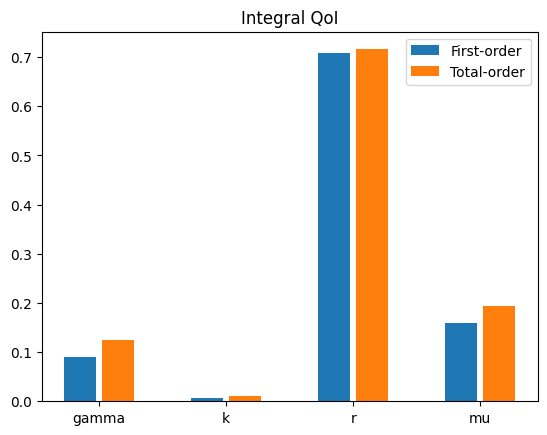

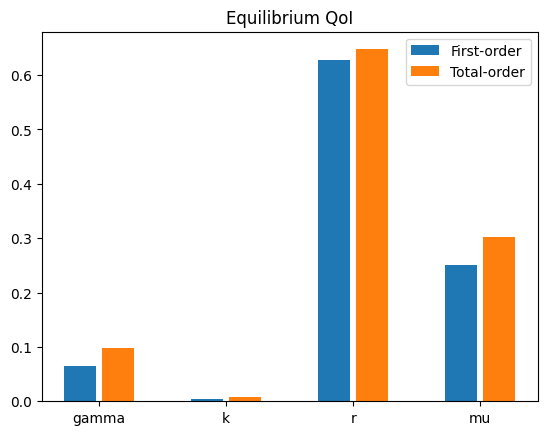

In [42]:
# Calculate Sobol indices (S_i: first order, ST_i: total order)

y_D_int = np.concatenate([I_int_A, I_int_B])
y_D_equi = np.concatenate([I_equi_A, I_equi_B])
f02_int = ((1/(2*M))**2) * np.sum(y_D_int)**2
f02_equi = ((1/(2*M))**2) * np.sum(y_D_equi)**2

S_i_int = np.zeros(4)
ST_i_int = np.zeros(4)
S_i_equi = np.zeros(4)
ST_i_equi = np.zeros(4)
for k in range(4):
    S_i_int[k] = ((1/M) * (np.dot(I_int_B.T, I_int_C[:, k]) - np.dot(I_int_B.T, I_int_A))) / ((1/(2*M)) * np.dot(y_D_int.T, y_D_int) - f02_int)
    ST_i_int[k] = ((1/(2*M)) * (np.dot(I_int_A.T, I_int_A) - 2 * np.dot(I_int_A.T, I_int_C[:, k]) + np.dot(I_int_C[:, k].T, I_int_C[:, k]))) / ((1/(2*M)) * np.dot(y_D_int.T, y_D_int) - f02_int)

    S_i_equi[k] = ((1/M) * (np.dot(I_equi_B.T, I_equi_C[:, k]) - np.dot(I_equi_B.T, I_equi_A))) / ((1/(2*M)) * np.dot(y_D_equi.T, y_D_equi) - f02_equi)
    ST_i_equi[k] = ((1/(2*M)) * (np.dot(I_equi_A.T, I_equi_A) - 2 * np.dot(I_equi_A.T, I_equi_C[:, k]) + np.dot(I_equi_C[:, k].T, I_equi_C[:, k]))) / ((1/(2*M)) * np.dot(y_D_equi.T, y_D_equi) - f02_equi)

fig, ax = plt.subplots()
label_pts = np.array([1,2,3,4])
Si_pts = np.array([0.85, 1.85, 2.85, 3.85])
STi_pts = np.array([1.15,2.15,3.15,4.15])
ax.bar(Si_pts, S_i_int, label='First-order',width=0.25)
ax.bar(STi_pts, ST_i_int, label='Total-order',width=0.25)
ax.set_xticks(label_pts)
ax.set_xticklabels(['gamma', 'k', 'r', 'mu'])
ax.legend()
ax.set_title('Integral QoI')

fig, ax = plt.subplots()
ax.bar(Si_pts, S_i_equi, label='First-order',width=0.25)
ax.bar(STi_pts, ST_i_equi, label='Total-order',width=0.25)
ax.set_xticks(label_pts)
ax.set_xticklabels(['gamma', 'k', 'r', 'mu'])
ax.legend()
ax.set_title('Equilibrium QoI')

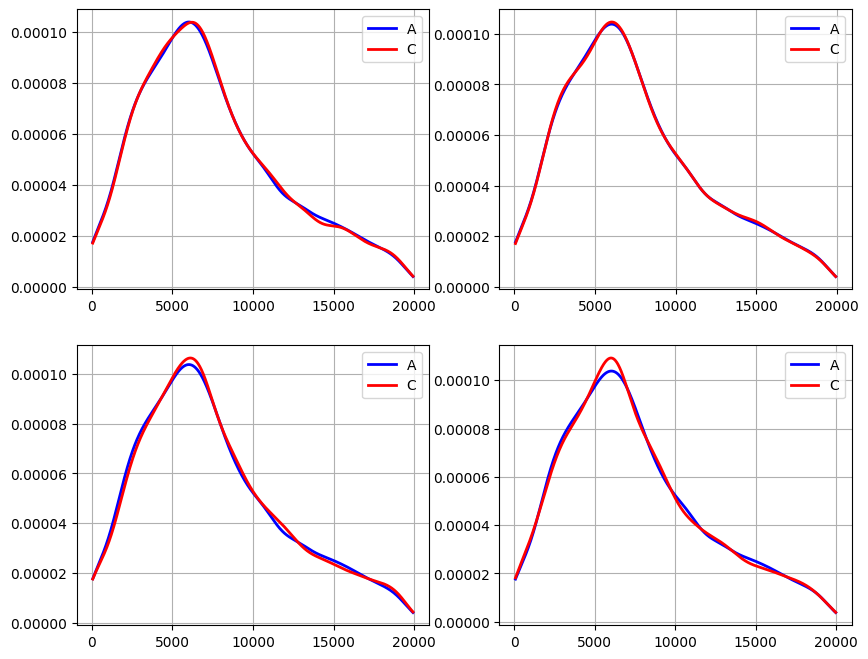

In [48]:
# Plot a PDF of the output values to see how there may be a shift in QoI when A has one column replaced

plt.figure(100, figsize=(10, 8))
for k in range(4):
    plt.subplot(2, 2, k + 1)
    fA = gaussian_kde(I_int_A.flatten())
    fC = gaussian_kde(I_int_C[:, k])
    x = np.linspace(min(min(I_int_A), min(I_int_C[:, k])), max(max(I_int_A), max(I_int_C[:, k])), 1000)
    plt.plot(x, fA(x.T), 'b', lw=2)
    plt.plot(x, fC(x.T), 'r', lw=2)
    plt.legend(['A', 'C'])
    plt.grid(True)

plt.show()